# どのくらいのトピックに分類するのが程よいか調べる

In [13]:
from tqdm import tqdm
import gensim
from gensim import corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
import pandas as pd
import numpy as np

# 対象データを読み込む
df = pd.read_csv('tokenized/merge_tokenized.csv')

# 訓練データの整形
texts = []
sentenses = df['tokens'].values
for row in sentenses:
    texts.append(row.strip().split(' '))

# データからコーパスを取得
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

start = 2
limit = 15
step = 1

coherence_vals = []
perplexity_vals = []

for n_topic in tqdm(range(start, limit, step)):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=n_topic, random_state=0)
    perplexity_vals.append(np.exp2(-lda_model.log_perplexity(corpus)))
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_vals.append(coherence_model_lda.get_coherence())

100%|██████████| 13/13 [05:00<00:00, 23.13s/it]


# 学習した結果を図示する。
トピック数毎の制度や品質を評価する。どの程度のトピック数に分類するのが良さそうか判断する参考となる。
評価項目は下記の通りであり、これらの両方の数値が良好なトピック数が適していると考えられる。

* coherence : トピックの品質を測る評価指標、高い方が良い。
* perplexity : モデルの予測精度の評価指標、低い方が良い。

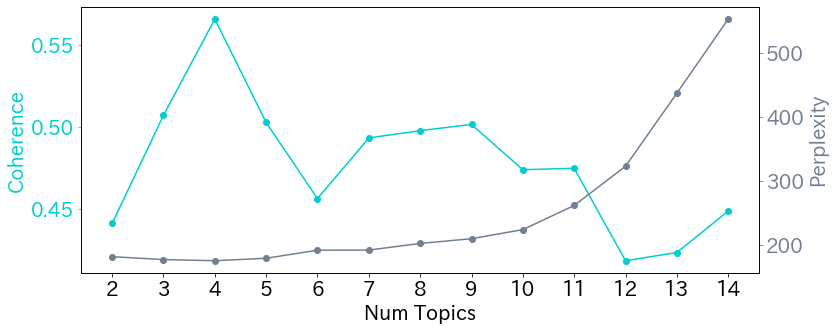

In [14]:
# pyLDAvis
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

pyLDAvis.enable_notebook()

plt.rcParams['font.family'] = 'IPAexGothic'
plt.rcParams["font.size"] = 20

x = range(start, limit, step)

fig, ax1 = plt.subplots(figsize=(12,5))

# coherence
c1 = 'darkturquoise'
ax1.plot(x, coherence_vals, 'o-', color=c1)
ax1.set_xlabel('Num Topics')
ax1.set_ylabel('Coherence', color=c1); ax1.tick_params('y', colors=c1)

# perplexity
c2 = 'slategray'
ax2 = ax1.twinx()
ax2.plot(x, perplexity_vals, 'o-', color=c2)
ax2.set_ylabel('Perplexity', color=c2); ax2.tick_params('y', colors=c2)

# Vis
ax1.set_xticks(x)
fig.tight_layout()
plt.show()

# LDAトピックモデルの作成
上記で評価して良さそうなトピックス数で分類してみる。

In [15]:
# 分類するトピック数を設定する。上記の分類でPerplexityが低くCoherenceが高いトピック数を選択する。
NUM_TOPICS = 4

from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from collections import defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd

# カテゴリ数を取得する。
df = pd.read_csv('tokenized/merge_tokenized.csv')

# 訓練データの整形
texts = []
sentenses = df['tokens'].values
for row in sentenses:
    texts.append(row.strip().split(' '))

# データからモデル作成
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
lda_model = LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary)

# LDAトピックモデルのWordCloud
生成されたトピックについて、代表的な単語を可視化する。各トピックがどのような内容で分類されているのかは、分析者がトピックの内容から判断する。

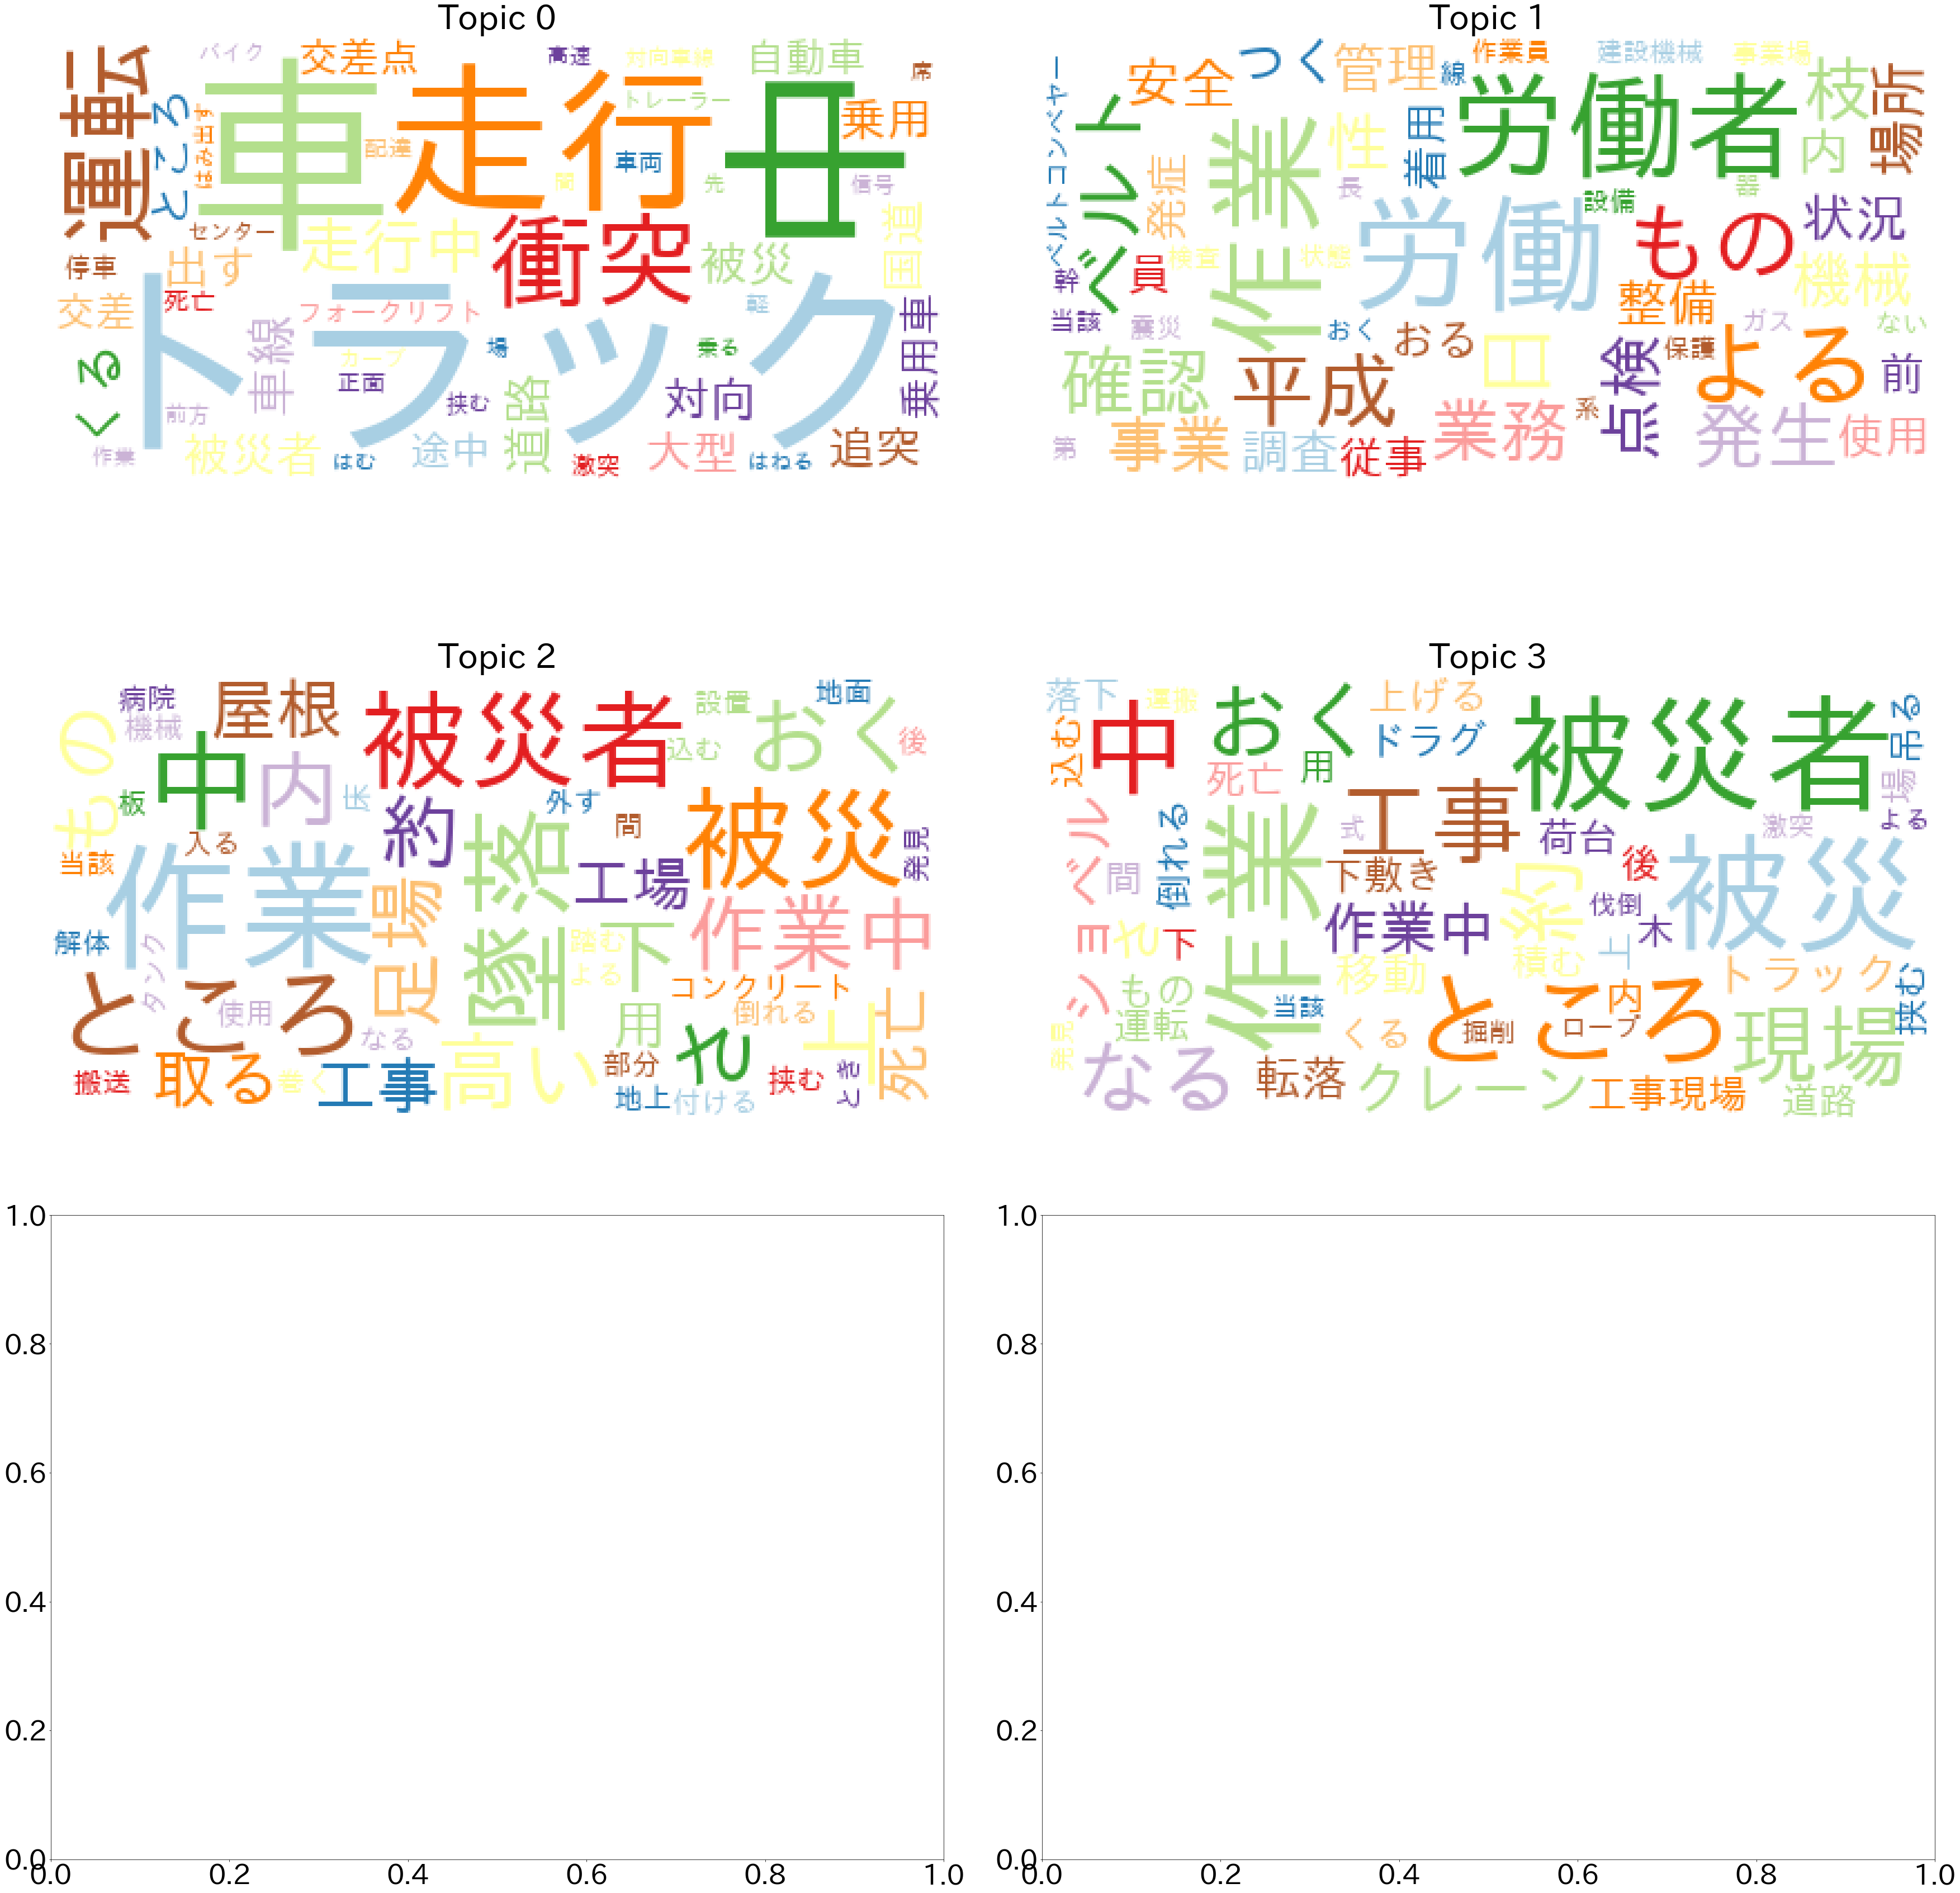

In [16]:
from wordcloud import WordCloud
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'IPAexGothic'
plt.rcParams["font.size"] = 50

fig, axs = plt.subplots(ncols=2, nrows=int(lda_model.num_topics/2 + 1), figsize=(50,50))
axs = axs.flatten()

def color_func(word, font_size, position, orientation, random_state, font_path):
    return 'darkturquoise'

for i, t in enumerate(range(lda_model.num_topics)):

    x = dict(lda_model.show_topic(t, 50))
    im = WordCloud(
        font_path='/usr/share/fonts/truetype/ipaexg.ttf',
        background_color='white',
        color_func=color_func,
        random_state=0
    ).generate_from_frequencies(x)
    axs[i].imshow(im.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(t))
        
plt.tight_layout()
plt.show()

# トピック間の距離や、トピックを表す代表的な単語を可視化する。

In [17]:
import warnings
warnings.filterwarnings('ignore')

# Vis PCoA
# lda_model = LdaModel(corpus=corpus, num_topics=4, id2word=dictionary)
vis_pcoa = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)
vis_pcoa

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.210392  0.183166       1        1  20.297606
1      0.307303  0.099780       2        1  13.414766
2      0.001393 -0.200012       3        1  33.356579
3     -0.098304 -0.082934       4        1  32.931053, topic_info=     Category          Freq  Term         Total  loglift  logprob
859   Default   8124.000000     車   8124.000000  30.0000  30.0000
1258  Default  10475.000000  トラック  10475.000000  29.0000  29.0000
816   Default   5118.000000    労働   5118.000000  28.0000  28.0000
1483  Default   5988.000000    走行   5988.000000  27.0000  27.0000
1237  Default   4349.000000   労働者   4349.000000  26.0000  26.0000
...       ...           ...   ...           ...      ...      ...
154    Topic4   2126.694092    死亡   6317.141602   0.0221  -5.1566
10     Topic4   2144.986328     上   7151.219727  -0.0934  -5.1481
28     Topic4   2164.587646     内   7484.467773  -0.1298  -5.1390
50     Topic4   2205.573730    もの   8251.265625  -0.2086  -5.1202
27     Topic4   1835.414062     下   5934.201172  -0.0627  -5.3039

[332 rows x 6 columns], token_table=       Topic      Freq Term
term                       
137        1  0.052768   おく
137        2  0.045523   おく
137        3  0.448854   おく
137        4  0.452855   おく
162        1  0.049455   おる
...      ...       ...  ...
17988      4  0.003843   震災
78         1  0.031221   高い
78         2  0.002670   高い
78         3  0.744575   高い
78         4  0.221627   高い

[840 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])